In [4]:
from pandas import read_csv, DataFrame,concat,notnull,isnull,Series,IndexSlice
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [5]:
cba = read_csv("data_cba/cba_no_flood_million_rs_per_ha.csv")

In [6]:
cba[['min','max']]=cba[['min','max']]*2300*10**(-3)

In [7]:
cba

,option,min,max
0,wetland with no recreation,2.3,6.9
1,wetland with recreation,6.9,18.4
2,lake,6.9,11.5
3,land,34.5,43.7


In [8]:
list(cba.option)

['wetland with no recreation', 'wetland with recreation', 'lake', 'land']

In [9]:
cba.ix[cba.option=="wetland with recreation",['min','max']].values

array([[  6.9,  18.4]])

In [10]:
losses = read_csv("all_economic_losses.csv")

In [11]:
losses.annuallosses.describe()

count    10800.000000
mean       191.571911
std        197.257711
min         10.291773
25%         61.638753
50%        123.734778
75%        249.434015
max       1917.144493
Name: annuallosses, dtype: float64

In [12]:
losses.columns

Index(['GDPgr', 'Popgr', 'losses_share', 'urban_policy', 'scenario_number',
       'wetland_loss', 'climate_change', 'runoff', 'bndconditions',
       'annuallosses'],
      dtype='object')

In [13]:
indx1 = ['GDPgr', 'Popgr', 'losses_share', 'urban_policy', \
                                'climate_change', 'runoff', 'bndconditions']
indx2 = ['GDPgr', 'Popgr', 'losses_share', 'urban_policy', 'wetland_loss', \
                                'climate_change', 'runoff', 'bndconditions']

In [14]:
c = (losses.drop("scenario_number",axis=1).query('wetland_loss>0').set_index(indx1) - \
 losses.drop("scenario_number",axis=1).query('wetland_loss==0').set_index(indx1)).reset_index().set_index(indx2).rename(columns={"annuallosses":"diffannuallosses"})

new_losses = concat([losses.set_index(indx2),c],axis=1).reset_index().fillna(0)

In [15]:
new_losses.diffannuallosses.describe()

count    10800.000000
mean        32.731160
std         54.071096
min          0.000000
25%          1.192781
50%         11.855800
75%         40.205950
max        635.156542
Name: diffannuallosses, dtype: float64

In [16]:
endyear=2040

In [17]:
npv=DataFrame()
bl_min = cba.ix[cba.option=="land","min"].values
bl_max = cba.ix[cba.option=="land","max"].values
for option in ['wetland with no recreation', 'wetland with recreation', 'lake']:
    npv_temp = new_losses.copy()
    cb_min = cba.ix[cba.option==option,"min"].values
    cb_max = cba.ix[cba.option==option,"max"].values
    for cb in [cb_min,(cb_min+cb_max)/2,cb_max]:
        for bl in [bl_min,(bl_min+bl_max)/2,bl_max]:
            npv_temp["cost"] = npv_temp.diffannuallosses+1/100*npv_temp.wetland_loss*\
                               cb*((1+npv_temp.Popgr)**(endyear-2013)*(1+npv_temp.GDPgr)**(endyear-2013))
            npv_temp["benef"] = 1/100*(npv_temp.wetland_loss)*\
                               bl*((1+npv_temp.Popgr)**(endyear-2013)*(1+npv_temp.GDPgr)**(endyear-2013))
            npv_temp["npv"]   = npv_temp["benef"]-npv_temp["cost"]
            npv_temp.ix[:,"option"] = option
            npv_temp.ix[:,"cb"] = cb
            npv_temp.ix[:,"bl"] = bl
            npv = npv.append(npv_temp)

In [18]:
npv.cost.describe()

count    291600.000000
mean         56.001278
std          81.866996
min           0.000000
25%           3.202748
50%          24.159623
75%          74.232893
max         961.642335
Name: cost, dtype: float64

In [19]:
npv_res=DataFrame()
bl_min = cba.ix[cba.option=="land","min"].values
bl_max = cba.ix[cba.option=="land","max"].values
for option in ['wetland with no recreation', 'wetland with recreation', 'lake']:
    npv_temp = new_losses.copy()
    cb_min = cba.ix[cba.option==option,"min"].values
    cb_max = cba.ix[cba.option==option,"max"].values
    for cb in [cb_min,(cb_min+cb_max)/2,cb_max]:
        for bl in [bl_min,(bl_min+bl_max)/2,bl_max]:
            for sh_soc in [0.5,1]:
                npv_temp["cost"] = npv_temp.diffannuallosses/0.65+1/100*npv_temp.wetland_loss*\
                                   cb*((1+npv_temp.Popgr)**(2040-2013)*(1+npv_temp.GDPgr)**(2040-2013))
                npv_temp["benef"] = sh_soc*1/100*(npv_temp.wetland_loss)*\
                                   bl*((1+npv_temp.Popgr)**(2040-2013)*(1+npv_temp.GDPgr)**(2040-2013))
                npv_temp["npv"]   = npv_temp["benef"]-npv_temp["cost"]
                npv_temp.ix[:,"option"] = option
                npv_temp.ix[:,"cb"] = cb
                npv_temp.ix[:,"bl"] = bl
                npv_temp.ix[:,"sh_soc"] = sh_soc
                npv_res = npv_res.append(npv_temp)

In [20]:
npv_res.cost.describe()

count    583200.000000
mean         73.625749
std         109.787126
min           0.000000
25%           3.938970
50%          30.963938
75%          96.812869
max        1303.649704
Name: cost, dtype: float64

In [22]:
indx3 = ['GDPgr', 'Popgr', 'losses_share', 'urban_policy', 'wetland_loss', \
                                'climate_change', 'runoff', 'bndconditions','option','cb','bl','sh_soc']
indx4 = ['GDPgr', 'Popgr', 'losses_share', 'urban_policy', \
                                'climate_change', 'runoff', 'bndconditions','option','cb','bl','sh_soc']

In [23]:
jojo=npv_res.set_index(indx3).npv.unstack("wetland_loss")
zz = jojo.apply(lambda s:s-jojo.max(axis=1))
regret = zz.stack().reset_index().rename(columns={0:"regret"})

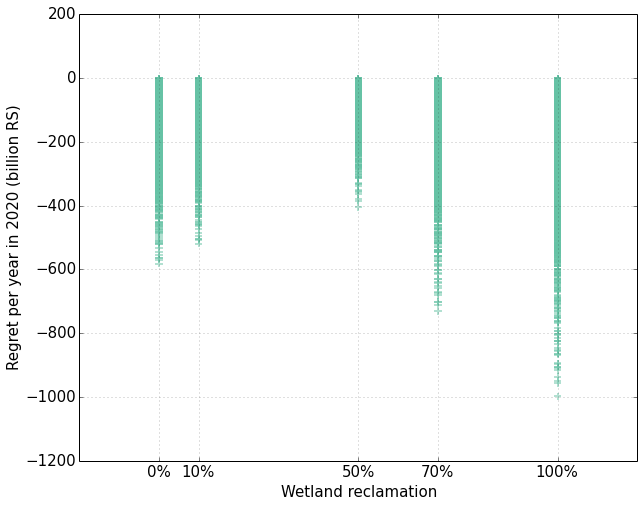

In [25]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

#select = (regret.GDPgr==0)&(regret.Popgr==0)&(regret.urban_policy==0)&(regret.climate_change==0)
#select = (regret.option=="wetland with recreation")
select = (regret.climate_change>0)
grouped = regret.ix[select,:].groupby("wetland_loss")

for i, (name, group) in enumerate(grouped):
    y1 = group.ix[group.option=="wetland with recreation","regret"]
    y2 = group.ix[group.option=="lake","regret"]
    plt.scatter([int(name)]*len(y1),y1,\
               marker='+',facecolors='none',edgecolors='#66c2a5',linewidth='2',s=50,alpha=0.5)
    #plt.scatter([int(name)+2]*len(y2),y2,\
     #          marker='+',facecolors='none',edgecolors='red',linewidth='2',s=50,alpha=0.5)
    
plt.xticks([0,10,50,70,100])
aa = ["{}%".format(i) for i in [0,10,50,70,100]]
ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)

plt.ylabel('Regret per year in 2020 (billion RS)')
plt.xlabel('Wetland reclamation')

In [18]:
#select = (losses.GDPgr==0)&(losses.Popgr==0)&(losses.urban_policy==0)&(losses.climate_change==0)
#grouped = losses.ix[select,:].groupby("wetland_loss")
grouped = npv.groupby("wetland_loss")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    print(min(group.npv))
    

-10.2080427749
-113.19908643
-265.657114117
-349.48147277


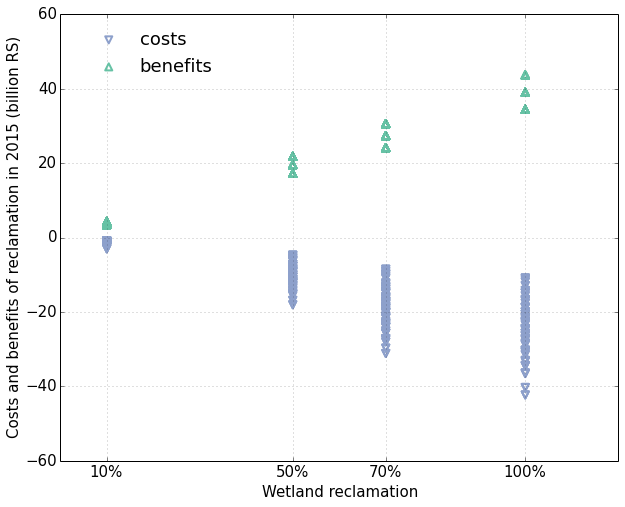

In [19]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

select = (npv.GDPgr==0)&(npv.Popgr==0)&(npv.urban_policy==0)&(npv.climate_change==0)
#grouped = losses.ix[select,:].groupby("wetland_loss")
grouped = npv.ix[select,:].groupby("wetland_loss")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.ix[group.option=="wetland with recreation","cost"]
    yb = group.ix[group.option=="wetland with recreation","benef"]
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#8da0cb',linewidth='2',s=50,alpha=1,label="costs")
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#66c2a5',linewidth='2',s=50,alpha=1,label="benefits")
    if i==1:
        ax.legend(bbox_to_anchor=[-0.2,0.5,0.5,0.5],frameon=False,scatterpoints=1)
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)

plt.ylabel('Costs and benefits of reclamation in 2015 (billion RS)')
plt.xlabel('Wetland reclamation')

0.465177143182
3.05967841907
7.24365933154
8.35833454255


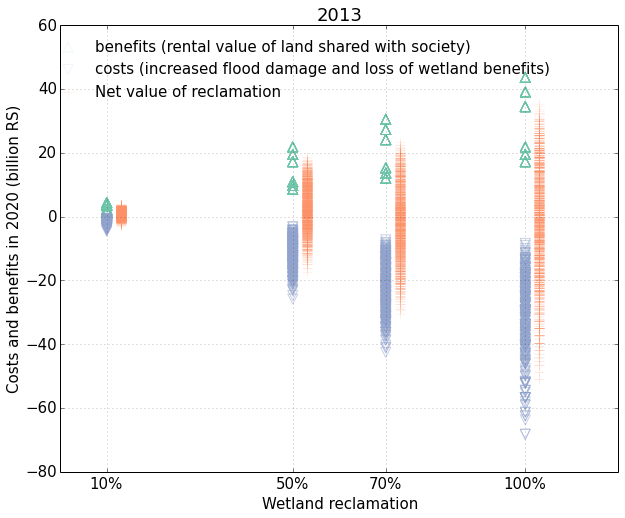

In [22]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change<2)
#grouped = losses.ix[select,:].groupby("wetland_loss")
grouped = npv_res.ix[select,:].groupby("wetland_loss")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    print(min(yc))
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#66c2a5',linewidth='1',s=100,alpha=0.1,\
                label="benefits (rental value of land shared with society)")
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#8da0cb',linewidth='1',s=100,alpha=0.1,\
                label="costs (increased flood damage and loss of wetland benefits)")
    plt.scatter([int(name)+3]*len(yn),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.1,\
                label="Net value of reclamation")
    if i==1:
        ax.legend(bbox_to_anchor=[0.4,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=15)
        #ax.annotate("No regret",xy=(int(name)+2,min(group.npv)))
    #if i>0:
        #ax.annotate("Max regret:\n{} billion RS\nper year".format(-np.rint(min(group.npv))).replace(".0",""),\
                #xy=(int(name)+4,min(group.npv)-10))
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)

#ax.set_ylim([-60,60])

plt.ylabel('Costs and benefits in 2020 (billion RS)')
plt.xlabel('Wetland reclamation')

plt.title("2013")

#plt.savefig("tada.png",dpi=400,bbox_inches="tight")

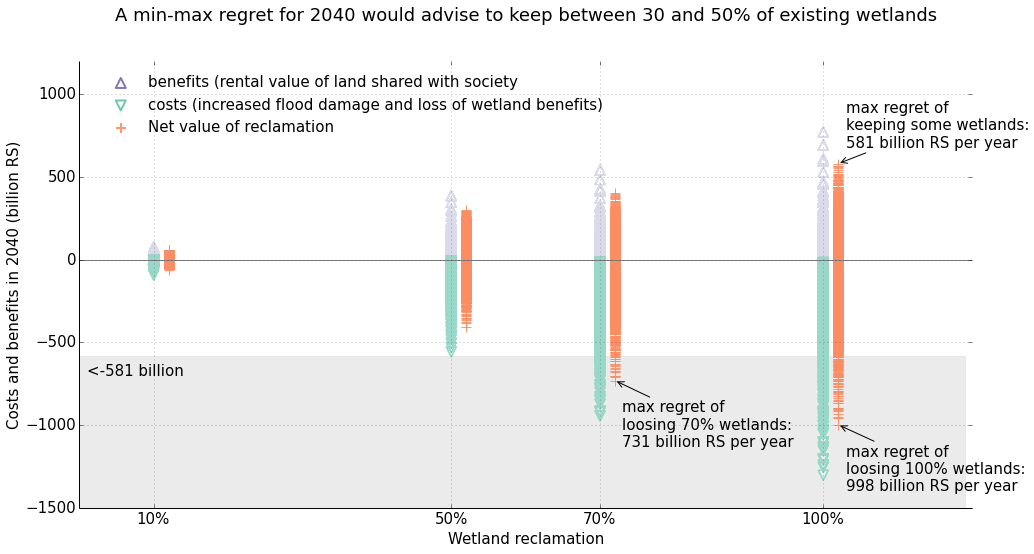

In [109]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(16,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (npv_res.urban_policy<2)&(npv_res.climate_change>0)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_loss")

plt.scatter(10,npv_res.benef.min(),marker='^',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.9,\
                label="benefits (rental value of land shared with society")

plt.scatter(10,npv_res.cost.min(),marker='v',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.9,\
                label="costs (increased flood damage and loss of wetland benefits)")

plt.scatter(12,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of reclamation")

ax.legend(bbox_to_anchor=[0.1,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=15)

#ax.fill_between(np.arange(0,120,1), 0, -494, color='#d9d9d9', alpha=0.2)
plt.plot([0,120],[0,0],color="grey")
ax.fill_between(np.arange(0,120,1), -581, -1500, color='#d9d9d9', alpha=0.5)

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
    if i==3:
        ax.annotate("max regret of\nloosing {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+3,min(yn)-400), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"))
        
    
    if i==4:
        ax.annotate("max regret of\nloosing {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+3,min(yn)-400), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"))
        
        ax.annotate("max regret of\nkeeping some wetlands:\n{} billion RS per year".format(np.rint(max(yn))).replace(".0",""),
                    xy=(int(name)+2, max(yn)), xycoords='data',
                    xytext=(int(name)+3, max(yn)+100), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3")
                    )
        
ax.annotate("<-581 billion",xy=(1, -700))
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-1500,1200])

plt.ylabel('Costs and benefits in 2040 (billion RS)')
plt.xlabel('Wetland reclamation')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("A min-max regret for 2040 would advise to keep between 30 and 50% of existing wetlands",\
         y=1.08)

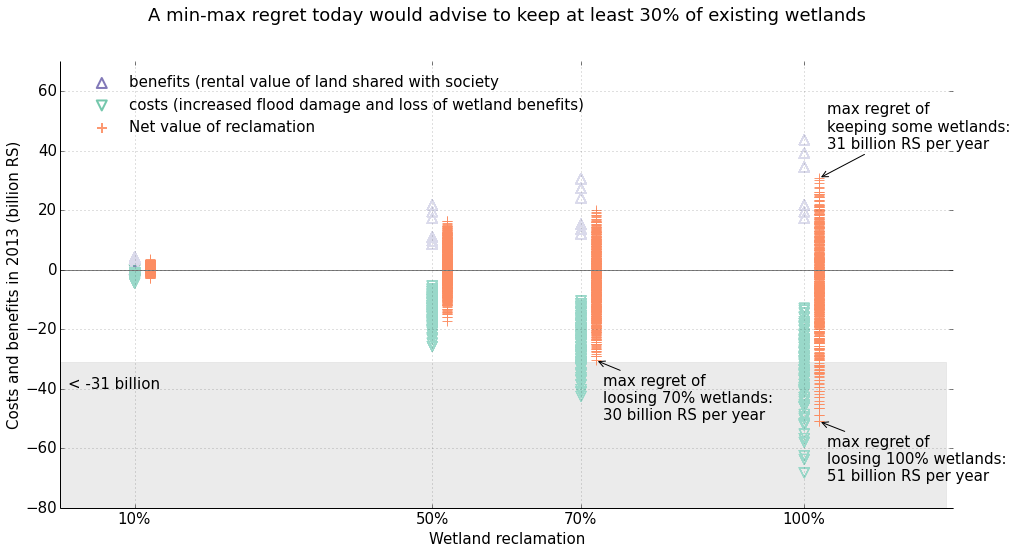

In [104]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(16,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change<2)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_loss")

plt.scatter(10,npv_res.benef.min(),marker='^',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.9,\
                label="benefits (rental value of land shared with society")

plt.scatter(10,npv_res.cost.min(),marker='v',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.9,\
                label="costs (increased flood damage and loss of wetland benefits)")

plt.scatter(12,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of reclamation")

ax.legend(bbox_to_anchor=[0.1,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=15)

#ax.fill_between(np.arange(0,120,1), 0, -494, color='#d9d9d9', alpha=0.2)
plt.plot([0,120],[0,0],color="grey")
ax.fill_between(np.arange(0,120,1), -31, -80, color='#d9d9d9', alpha=0.5)

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
    if i==3:
        ax.annotate("max regret of\nloosing {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+3,min(yn)-20), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"))
        
    
    if i==4:
        ax.annotate("max regret of\nloosing {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+3,min(yn)-20), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"))
        
        ax.annotate("max regret of\nkeeping some wetlands:\n{} billion RS per year".format(np.rint(max(yn))).replace(".0",""),
                    xy=(int(name)+2, max(yn)), xycoords='data',
                    xytext=(int(name)+3, max(yn)+10), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3")
                    )
        
ax.annotate("< -31 billion",xy=(1, -40))
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-80,70])

plt.ylabel('Costs and benefits in 2013 (billion RS)')
plt.xlabel('Wetland reclamation')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("A min-max regret today would advise to keep at least 30% of existing wetlands",\
         y=1.08)